In [25]:
import json

def inList(array , dictionary):
    for lval in array:
        for key, val in dictionary.items():
               for v in val:
                    if v in lval:
                          return key
                        
def inDict(string, dictionary):
    for key, val in dictionary.items():
        for v in val:
            if string.lower() in v.lower():
                return key
                        
def mapDegInfo(array):
    if len(array) % 2 > 2:
        return 'Magistrale'
    else:
        return 'Triennale'
    
def calcGraduationYears(degInfo, dateRanges):
    if dateRanges[0] < dateRanges[1]:
        return int(dateRanges[1])
    else:
        if degInfo == 'Triennale' or degInfo == 'Dottorato':
            return int(dateRanges[0]) + 3
        else:
            return int(dateRanges[0]) + 2    
    
    
degreeInfo = {
    'Dottorato': ['Dottorato', 'Phd','PhD','PHD', 'P.h.D', 'P.h.d','P.H.D'],
    'Magistrale': ['Magistrale','magistrale','specialistica','Specialistica',"Master's","master's"],
    'Triennale': ['Triennale',"Bachelor's",'triennale']
}

nameWrapperFile = 'nameWrapper.json'
jobLevelWrapperFile = 'jobLevelWrapper.json'
jobWrapperFile = 'jobWrapper.json'
educationWrapperFile = 'educationWrapper.json'
trueClusterFile = 'cluster.json'

nameWrapper = {}
jobLevelWrapper = {}
jobWrapper = {}
educationWrapper = {} 
trueCluster = {}

with open(nameWrapperFile) as json_name_wrapper:
    nameWrapper = json.load(json_name_wrapper)

with open(jobLevelWrapperFile) as json_job_level_wrapper:
    jobLevelWrapper = json.load(json_job_level_wrapper)    

with open(jobWrapperFile) as json_job_wrapper:
    jobWrapper = json.load(json_job_wrapper)

with open(educationWrapperFile) as json_edu_wrapper:
    educationWrapper = json.load(json_edu_wrapper)
    
with open(trueClusterFile) as json_cluster_wrapper:
    trueCluster = json.load(json_cluster_wrapper)
    
tag = ['h3', 'span']
classes = ['education__item education__item--degree-info','pv-entity__comma-item','pv-entity__school-name t-16 t-black t-bold', 't-16 t-black t-bold','profile-section-card__title']

<h1>Snippets</h1>

<p>In this first cell i decided to incapsulate all accessories functions and snippets that i will use in further code. Going into details there are three functions and other data structures used to scrape out some additional data from already processed html tags, now i proceed to explain their behaviour while i will explain how i use them the scraping section.
</p> 

<p>
<h3>Accessories Functions</h3><br>
<dl>
    <dt><bold><code>def inList(array, dictionary):</code></bold></dt>
    <dd>This function basically loop over all the elements of the array given as the first argument, and over the key value pair of the dictionary and if one of the values in the dictionary is contained in the array it returns the associated key </dd>
    <dt><bold><code>def inDict(string, dictionary):</code></bold></dt>
    <dd>similarly to the previous function described, this one takes as the first argument a string instead and loops over each value and key of the dictionary to check wether the string is contained as value of the dictionary and if so returns the associated key</dd>
    <dt><bold><code>def mapDegInfo(array)</code></bold></dt>
    <dd>This function check for the lenght of the array and if it exceeds two element it will return magistrale, otherwise it will return triennale</dd>
    <dt><bold><code>def calcGraduationYears(degInfo, dateRanges)</code></bold></dt>
    <dd>it estimates the graduation years for those fields where the graduation year is not available, depending on the currently enrolled degree</dd>
</dl>
</p>

<p>
<h3>Data structures</h3><br>
<dl>
    <dt><bold><code>degreeInfo</code></bold></dt>
    <dd>is a dictionary that incapsulates different kind of degrees and it is used to map through key the type of degree given the listed values.</dd>
    <dt><bold><code>nameWrapper</code></bold></dt>
    <dd>initially declared as empty, it is filled by entries that are stored in a json file format including key-value mapping that are used to infer the gender of an individual by her/his name</dd>
    <dt><bold><code>JobLevelWrapper</code></bold></dt>
    <dd>initially declared as empty, it is filled by entries that are stored in a json file format including key-value mapping that are used to infer the job qualification from the specific job</dd>
    <dt><bold><code>JobWrapper</code></bold></dt>
    <dd>initially declared as empty, it is filled by entries that are stored in a json file format including key-value mapping that are used to infer the job</dd>
    <dt><bold><code>EducationWrapper</code></bold></dt>
    <dd>initially declared as empty, it is filled by entries that are stored in a json file format including key-value mapping that are used to infer the education field</dd>
    <dt><bold><code>tag</code></bold></dt>
    <dd>in this array i encapsulate all of those html tag element that will be scraped in further code, thus containing elements of interest for the dataset of profiles </dd>
    <dt><bold><code>classes</code></bold></dt>
    <dd>in this array i encapsulate all of those class attributes of html tag element that will be scraped in further code</dd>
</dl>
</p>



In [26]:
import os
import numpy as np
import csv
import re
from bs4 import BeautifulSoup

files = os.listdir(".")

experiences = []
educations = []
expectedClus = []

profiles = []

for f in files:
    if f.endswith(".html"):
        with open(f, encoding='utf-8') as fp:
            soup = BeautifulSoup(fp)
            nameTags = (soup.find('h1', {'class':c}) for c in ['top-card-layout__title', 'text-heading-xlarge inline t-24 v-align-middle break-words'])
            nameText = next((nameTag for nameTag in nameTags if nameTag is not None), "")
            firstName = ""
            if nameText != "":
                firstName = nameText.get_text().strip().split(' ')[0].lower()
            gender = inList([firstName], nameWrapper)    
            regex = re.compile('.*experience.*')
            experienceSection = soup.find('section', {'class':regex})
            for el in experienceSection.find_all('span', {'class':'visually-hidden'}): el.decompose()
            experienceTags = (experienceSection.find_all(t, {'class': c}) for t in tag for c in classes)
            expText = next((exp for exp in experienceTags if len(exp) > 0), "")
            experience = [el.get_text().strip() for el in expText if el != ""]
            workLevel = inList(experience, jobLevelWrapper)
            regexEd = re.compile('.*education.*')
            educationSection = soup.find('section', {'class':regexEd})
            educationTags = (educationSection.find_all(tag[1], {'class':c}) for c in classes)
            edText = next((ed for ed in educationTags if len(ed) > 0), "")
            education = [el.get_text().strip() for el in edText if el != ""]
            educationTimes = [el.get_text() for el in educationSection.find_all('time')]
            clust = inList(experience, trueCluster)
            expectedClus.append(clust)
            infoDeg = inList(education, degreeInfo) if inList(education, degreeInfo) is not None else mapDegInfo(education)        
            profiles.append([experience, education, infoDeg, educationTimes, gender, workLevel])

print(profiles[:2])

[[['Training Specialist', 'Training Specialist', 'Legal Assistant Paralegal', 'Legal Affairs Specialist'], ['Master di I livello', 'Politiche di Sicurezza e Polizie Locali', 'Laurea Magistrale  LM in Giurisprudenza', 'Ragioniere perito commerciale - programmatore'], 'Magistrale', ['2015', '2009', '2014', '2004', '2009'], 'F', 'Quadro'], [["Esperienze di Lavoro all'Estero come Care Assistant,Barman,Waiter"], ['Scienze Politiche,Sociali ed Internazionali', 'Curriculum Sociologia', 'Diploma', 'Liceo Scientifico'], 'Triennale', ['2014', '2016', '2006', '2011'], 'M', 'Impiegato']]


<h1>Scraping section</h1>

<p>In this first huge part of code above i built a scraper almost from scratch using Beautiful Soup which is a python library i used to pull out data from the html files of linkedin profiles i manually downloaded in the current local directory. At this stage i scraped the most significant fields i could take out of a linkedin profile such as Jobs, Education, the type of degree, enrollment and graduation years, the gender of an individual and the professional status. This data will be combined in order to have some more insights using machine learning algorithm in order to classify and segment people that got a degree at University of Bologna. For what concerns the code to scrape out that data already described, even though i tried to be as general as possible, In order to fetch data from Job and Education sections i had to refer to html tag with specific class descriptor used by linkedin to format its elements. Going into further details, once i built the scraper around the html file i downloaded with <code>BeautifulSoup(fp)</code> i used the following APIs</p>

<p>
    <dl>
        <dt><bold><code>soup.find('h1', {'class':c}) for c in ['top-card-layout__title', 'text-heading-xlarge inline t-24 v-align-middle break-words'] </code></bold></dt>
        <dd>in this line of code i basically scraped the first name out of the profiles i downloaded in order then to use it to deduce the gender, in particular <code>soup.find</code> takes as first argument the html element containing the data and as the second argument it loops over a list of class attributes specific for the profile/html page downloaded that contains the first name</dd>
        <dt><bold><code>soup.find('section', {'class':regex})</code></bold></dt>
        <dd>this API it is used to address both html section containing data about work experience and education with the class attribute regex that incapsulates a regular expression used to address any word containing experience (related to the experience section) and education (related to education section), this code is furtherly scraped to the final result that incapsualtes inside a list all work entered in the profile and all degrees</dd>
        <dt><bold><code>educationSection.find_all('time')</code></bold></dt>
        <dd>in the time attribute are entered for each stored degree the enrollment year and the graduation year, in this case all are stored inside a list</dd>
        <dt><bold><code>infoDeg = inList(education, degreeInfo) if inList(education, degreeInfo) is not None else mapDegInfo(education)</code></bold></dt>
        <dd>in this line of code are used two functions: The first function takes the list with record of degree entered and the dictionary that act as wrapper for specific type of degree, returning the type itself, the second one is used in case of missing results from the first one. This may happen in the case where the type of degree is not explicitly stored in the profile and is thus inferred by the number of entered fields (e.g more than two titles imply that a profile has entered a high school title and bachelor's degree thus the deegree associated is a master's degree)</dd>
        <dt><bold><code>workLevel = inList(experience, jobLevelWrapper)</code></bold></dt>
        <dd>the InList function is used again in order to check the job from the experience list matching it to the job qualification wrapped for the specific job inside the jobLevelWrapper dictionary</dd>
        <dt><bold><code>gender = inList([firstName], nameWrapper)</code></bold></dt>
        <dd>as already stated previously gender is deduced by the name scraped from the profile</dd>
</dl>
</p>

<p>All of this scraped fields are put inside a list called profiles</p>
    
</p>

<h1>Persistency</h1>

<p>
in the chunck of code above the profiles previosly scraped are written in a csv file for the sake of persistency.
</p>

In [24]:
#loggin into a .csv file

import csv

header = ['Job','Education','InfoDeg','DateRange', 'Gender', 'WorkLevel']

csv_file = 'linkedin_profiles2.csv'
with open(csv_file, 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(header)
    writer.writerows(profiles)

<h1>First Look at the data</h1>

<p> in the following code i will give a brief description about the scraped data which is not yet well structured and of the operations i made to get to the desired dataset</p>

In [27]:
#reporting data
import pandas as pd
import numpy as np

df = pd.read_csv('linkedin_profiles2.csv', encoding='ISO-8859-1')
df.head()

,Job,Education,InfoDeg,DateRange,Gender,WorkLevel
0,"['Training Specialist', 'Training Specialist',...","['Master di I livello', 'Politiche di Sicurezz...",Magistrale,"['2015', '2009', '2014', '2004', '2009']",F,Quadro
1,"[""Esperienze di Lavoro all'Estero come Care As...","['Scienze Politiche,Sociali ed Internazionali'...",Triennale,"['2014', '2016', '2006', '2011']",M,Impiegato
2,"['docente di lettere', 'docente di lettere', '...",['Laurea Magistrale LM in Scienze Umanistiche...,Magistrale,"['2017', '2020', '2016', '2017', '2014', '2017']",F,Impiegato
3,"['Junior Software Developer', 'Promoter vendit...","['Laurea triennale', 'Ingegneria informatica',...",Triennale,"['2016', '2021']",M,Impiegato
4,"['IoT Edge Developer', 'Sviluppatore front-end']","['Laurea Magistrale LM', 'Ingegneria informat...",Magistrale,"['2019', '2020', '2015', '2018', '2010', '2015']",M,Impiegato


In [24]:
df.dtypes

Job          object
Education    object
InfoDeg      object
DateRange    object
Gender       object
WorkLevel    object
dtype: object

<p> the dataset, whose first elements are showcased by the head() method of pandas library, does still contain data that are a bit raw. Indeed, the columns displayed incapsulate inside lists all of those data scraped from html pages of linkedin profile such as all jobs registered in the experience section, all education information that could go from high school to P.h.d degrees and each enrollment and graduation date related to each education title entered. From this first sight at data it appears to me that this dataset needs to be modified a bit in order to keep just the information of interest for this work such as the last (most significant) education titles among P.h.D, bachelor or master degrees from University of Bologna, the last job inserted in the list of jobs and the last date range involving enrollment and graduation date of the associated degree.
</p>

In [4]:
df.shape

(496, 6)

In [28]:
from ast import literal_eval

df.Job = df.Job.apply(literal_eval)
df.Education = df.Education.apply(literal_eval)
df.DateRange = df.DateRange.apply(literal_eval)
df['ExpectedClus'] = expectedClus

in the cell above, since data fetched from the csv file containing linkedin profiles previously stored in arrays are perceived as one big string i applied a function in order to split those string back into the two lists of job, education and date range.  

In [6]:
print({k:jobWrapper[k] for k in list(jobWrapper.keys())[:2]})
print({k:educationWrapper[k] for k in list(educationWrapper.keys())[:2]})

{'Risorse umane': ['Responsabile Area Espansione', 'Senior Recruitment Officer', 'Analista Direzione Sviluppo Persone e Organizzazione', 'Training Specialist', 'HR'], 'Ristorazione': ['Assistente enologo', 'Barman', 'barista']}
{'Giurisprudenza': ['Giurisprudenza'], 'Scienze della comunicazione': ['Semiotica', 'Marketing', 'PubblicitÃ\xa0', 'Communication', 'Comunicazione', 'comunicazione', "comunicazione pubblica, d'impresa e pubblicitÃ\xa0", 'Mass media e Politica', 'Brand Strategy and Marketing', 'Scienze della comunicazione', 'Comunicazione e Digital Media', 'Scienze della Comunicazione', 'Comunicazione']}


As i anticipated previously, since education and job fields fetched from linkedin html pages could have entered with different naming even though they could be identified with a single category, i decided to compute some basic remapping. By the way in order to have a more clean and meaningful dataset to inspect i decided to map semantically similar jobs or degrees under one same branch. To clarify, for each profile whose work experience was Developer, Web Developer, Sviluppatore software and so on, i mapped those field under the same keyword Sviluppatore. Another field i processed from the raw data scraped previously are enrollmentYears of the last degree entered and the corresponding graduation years, to do that since there were some graduation years still missing due to a current enrollment to a degree, i used the calgGraduationYears accessory function previously defined to estimate the graduation years given the type of enrolled degree (such as for bachelor's degree the expected time is of three years).    

In [29]:
import warnings
import numpy as np
from functools import partial
warnings.filterwarnings('ignore')

df1 = df

mappedJobs = list(map(partial(inList, dictionary=jobWrapper), df1.Job))
mappedEdus = list(map(partial(inList, dictionary=educationWrapper), df1.Education))


df1['Job'] = mappedJobs
df1['Education'] = mappedEdus

df2 = df1[df1.DateRange.map(len) > 1]

enrollmentYears = [int(yearRange[0]) for yearRange in df2.DateRange]
graduationYears = list(map(calcGraduationYears, df2.InfoDeg , df2.DateRange))

df3 = df2

df3.drop('DateRange', axis = 1, inplace= True)
df3['enrollmentYears'] = enrollmentYears
df3['graduationYears'] = graduationYears

once the values are mapped i built another dataset switching the old values with the new ones whose first rows are showed in the following cells. After this small processing the dataset, fullfilled with more meaningful and easy-to-read data is ready to be scanned to get the first insights.  

In [30]:
df3.dropna(inplace=True)
expectedClus = df3['ExpectedClus']
df3.drop('ExpectedClus', axis = 1, inplace = True)

print(df3.dtypes)
print(df3.shape)
df3.head()

Job                object
Education          object
InfoDeg            object
Gender             object
WorkLevel          object
enrollmentYears     int64
graduationYears     int64
dtype: object
(427, 7)


,Job,Education,InfoDeg,Gender,WorkLevel,enrollmentYears,graduationYears
0,Risorse umane,Giurisprudenza,Magistrale,F,Quadro,2015,2017
1,Ristorazione,Scienze politiche,Triennale,M,Impiegato,2014,2016
2,Insegnante,Lettere e Filosofia,Magistrale,F,Impiegato,2017,2020
3,Sviluppatore,Ingegneria Informatica,Triennale,M,Impiegato,2016,2021
4,Sviluppatore,Ingegneria Informatica,Magistrale,M,Impiegato,2019,2020


In [14]:
df3.to_csv('out.csv')

In the chunck of code above in order to display a rapresentation of the report of the data as fancy as possible i used the pandas-profiling module in order to save it in a html file. Basically what it does is to provide a more enriched rappresentation of the API describe() from pandas which is used as well to generate some descriptive statistics about the features of the dataset to give some insights about it, and it calculates how correlated the features are.  

<h1>Data preprocessing</h1>

<p>
in the following cells i prepare the data with preprocessing operator in order to fit the dataset at best for the further classifications.
</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score 

random_state = 15
np.random.seed(random_state)

In [29]:
#sbn.catplot(df1)
df1.head()

,Job,Education,InfoDeg,DateRange,Gender,WorkLevel,ExpectedClus
0,Risorse umane,Giurisprudenza,Magistrale,"[2015, 2009, 2014, 2004, 2009]",F,Quadro,1
1,Ristorazione,Scienze politiche,Triennale,"[2014, 2016, 2006, 2011]",M,Impiegato,0
2,Insegnante,Lettere e Filosofia,Magistrale,"[2017, 2020, 2016, 2017, 2014, 2017]",F,Impiegato,3
3,Sviluppatore,Ingegneria Informatica,Triennale,"[2016, 2021]",M,Impiegato,0
4,Sviluppatore,Ingegneria Informatica,Magistrale,"[2019, 2020, 2015, 2018, 2010, 2015]",M,Impiegato,0


In [31]:
df = pd.read_csv('out.csv')
df.head()

df1 = df.iloc[:, 1:]

print(df1.head())

transf_dtype = np.int32

InfoDeg = ['Triennale','Magistrale','Dottorato']
WorkLevel = ['Impiegato','Quadro','Dirigente']

ordinal = OrdinalEncoder(categories=[InfoDeg, WorkLevel])
categorical = OneHotEncoder(dtype = transf_dtype, sparse=False)

df_categorical = df1.drop(columns=['InfoDeg','WorkLevel','enrollmentYears','graduationYears']) 
df_ordinal = df1.loc[:,['InfoDeg','WorkLevel']]

cat = categorical.fit_transform(df_categorical) 
cols = categorical.get_feature_names_out()

adj_cols = list(map(lambda x : x.replace('Job_','').replace('Gender_','').replace('Education_',''), cols))

X_cat = pd.DataFrame(cat, columns=adj_cols)

ordin = ordinal.fit_transform(df_ordinal) 
X_ordinal = pd.DataFrame(ordin, columns= ['InfoDeg','WorkLevel'])

X_p = pd.concat([X_cat, X_ordinal, df1.loc[:, ['enrollmentYears','graduationYears']]], axis=1)

print(X_cat.shape)
print(X_ordinal.shape)

X_p

             Job               Education     InfoDeg Gender  WorkLevel  \
0  Risorse umane          Giurisprudenza  Magistrale      F     Quadro   
1   Ristorazione       Scienze politiche   Triennale      M  Impiegato   
2     Insegnante     Lettere e Filosofia  Magistrale      F  Impiegato   
3   Sviluppatore  Ingegneria Informatica   Triennale      M  Impiegato   
4   Sviluppatore  Ingegneria Informatica  Magistrale      M  Impiegato   

   enrollmentYears  graduationYears  
0             2015             2017  
1             2014             2016  
2             2017             2020  
3             2016             2021  
4             2019             2020  
(427, 47)
(427, 2)


,Analista Finanziario/Economico,Analista informatico,Arte,Assistente sociale,Autore,Banca,Commerciale,Commercialista,Comunicazione,Consulente Finanziario/Economico,...,Matematica e Fisica,Scienze della comunicazione,Scienze politiche,Statistica,F,M,InfoDeg,WorkLevel,enrollmentYears,graduationYears
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1.0,1.0,2015,2017
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.0,0.0,2014,2016
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1.0,0.0,2017,2020
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,0.0,2016,2021
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,0.0,2019,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.0,0.0,2005,2009
423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,0.0,2019,2021
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,0.0,1998,2010
425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,0.0,2019,2021


<p>
As already stated above, in order to feed the further Decision tree classifier that i will instantiate to classify some instances, since most of the data fetched is categorical i had to perform some preprocessing that i explain in few words. I instantiated two processors from the sklearn library which are <code>OneHotEncoder</code> and <code>OrdinalEncoder</code>. The first one is used to map the nominal features which are Job, Education and Gender while the second one is used for WorkLevel and Type of Degree since they can express a natural ordering   
</p>

<h1>Classification</h1>

<p>in the following code i will split the dataset into independent variable (features) used to classify the independent (labels), in order to this fit the decision trees and tune them for achieve an accuracy score as high as possible. In particular my concern is to split the dataset two times, one to set the qualification of the job as the variable to be predicted and the other one to make a guess of what the graduation year is with supervised data.</p>

In [8]:
yw, Xw = X_p.loc[:, 'WorkLevel'], X_p.drop(columns = ['WorkLevel'])

print(yw.head())
print(Xw.head())

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: WorkLevel, dtype: float64
   Analista Finanziario/Economico  Analista informatico  Arte  \
0                               0                     0     0   
1                               0                     0     0   
2                               0                     0     0   
3                               0                     0     0   
4                               0                     0     0   

   Assistente sociale  Autore  Banca  Commerciale  Commercialista  \
0                   0       0      0            0               0   
1                   0       0      0            0               0   
2                   0       0      0            0               0   
3                   0       0      0            0               0   
4                   0       0      0            0               0   

   Comunicazione  Consulente Finanziario/Economico  ...  Lingue  \
0              0                                 0

<p>In the chunck of code above as already stated i set the WorkLevel as label to be predicted in order to asses the accuracy of the decision trees given the scraped data.</p> 

In [9]:
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw)

clf = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
clf.fit(Xw_train, yw_train)

yw_t_pred = clf.predict(Xw_test)
accuracy_test = accuracy_score(yw_test, yw_t_pred) * 100
print(f'accuracy on test set is {accuracy_test:.2f}%')
max_depth = clf.tree_.max_depth
print(max_depth)

accuracy on test set is 72.90%
19


<p>In order to train the decision tree with the set variable i splitted the data with train test split and train on the training set making a first test to set the max depth that i use to tune the tree </p>

In [10]:
scores = []
hyper_par = range(1, max_depth+1)
for depth in hyper_par:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth, random_state=random_state)
    clf.fit(Xw_train, yw_train)
    yw_pred_test = clf.predict(Xw_test)
    scores.append(accuracy_score(yw_test, yw_pred_test) * 100)

print(f"max depth of tuned decision tree is {np.argmax(scores)}")

max depth of tuned decision tree is 3


In [11]:
depth = np.argmax(scores)
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth+1, random_state=random_state)
clf.fit(Xw_train, yw_train)
yw_pred_test = clf.predict(Xw_test)
accuracy_t = accuracy_score(yw_test, yw_pred_test)*100

print(f'max accuracy achieved with tuned decision tree is {accuracy_t:.1f}%')

max accuracy achieved with tuned decision tree is 77.6%


<p>
In the code above i proceeded on looping over the trained decision tree with different depths in order to find the optimal one that could give the best accuracy score possible. This resulted into a slicely increased accuracy going from a 72.9 percentage to a final 77.6 percentage of accuracy to predict the level of work expected for the given data.
</p>

In [12]:
Xg, yg = X_p.drop(columns = ['graduationYears'], axis = 1), X_p.loc[:, 'graduationYears']

<p>
Here i set graduation years as the label to be predicted in order to asses what could be the accuracy score on a guess of the graduation year
</p>

In [13]:
print(Xg.head())
print(yg.head())

   Analista Finanziario/Economico  Analista informatico  Arte  \
0                               0                     0     0   
1                               0                     0     0   
2                               0                     0     0   
3                               0                     0     0   
4                               0                     0     0   

   Assistente sociale  Autore  Banca  Commerciale  Commercialista  \
0                   0       0      0            0               0   
1                   0       0      0            0               0   
2                   0       0      0            0               0   
3                   0       0      0            0               0   
4                   0       0      0            0               0   

   Comunicazione  Consulente Finanziario/Economico  ...  Lingue  \
0              0                                 0  ...       0   
1              0                                 0  ...     

In [14]:
xg_train, xg_test, yg_train, yg_test = train_test_split(Xg, yg)

In [15]:
clf = DecisionTreeClassifier(criterion = 'entropy', random_state=random_state)
clf.fit(xg_train, yg_train)
yg_pred = clf.predict(xg_test)
accuracy = accuracy_score(yg_test, yg_pred) * 100
print(f'The accuracy on the test set is {accuracy:.2f}%')
depth = clf.tree_.max_depth
print(clf.tree_.max_depth)

The accuracy on the test set is 42.06%
21


In [16]:
pars = range(1, depth+1)
scores = []

for par in pars:
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=par)
    clf.fit(xg_train, yg_train)
    yg_pred = clf.predict(xg_test)
    scores.append(accuracy_score(yg_test, yg_pred)*100)
    
best_depth = np.argmax(scores)+1 
print(f'max depth of tuned decision tree is {best_depth}')

max depth of tuned decision tree is 6


In [22]:
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth = best_depth)
clf.fit(xg_train, yg_train)
yg_pred = clf.predict(xg_test)
accuracy = accuracy_score(yg_pred,yg_test) * 100
print(f'max accuracy achieved with tuned decision {accuracy:.2f}%')


max accuracy achieved with tuned decision 43.93%


<p>As i made before i tuned the tree to achieve an increase of the performance as well</p>

<h1>Clustering</h1>

<p>In the code that follows i extracted a part of the dataset in order to group profiles based on Education and Job using clustering algorithm and i tried to asses the accuracy of the clustered label comparing the mismatch with clustering label that i handly picked</p>.

<p>
First of all i tried to give a visual glimpse of the pairs of job/education by using plotting a graph using the catplot library that associates descrete values with categorical data, in order to do that given that both the attributes where categorical i proceeded with a raw transformation of jobs into numerical labels.   
</p>

In [52]:
df2 = df1.loc[:, ['Job','Education','WorkLevel']]
df2.head()

,Job,Education,WorkLevel
0,Risorse umane,Giurisprudenza,Quadro
1,Ristorazione,Scienze politiche,Impiegato
2,Insegnante,Lettere e Filosofia,Impiegato
3,Sviluppatore,Ingegneria Informatica,Impiegato
4,Sviluppatore,Ingegneria Informatica,Impiegato


In [53]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

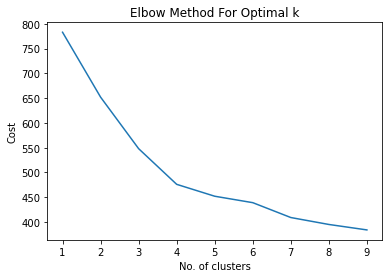

In [54]:
df_clus = df2
cost = []

cluster = range(1, 10)
for k in cluster:
    kmode = KModes(n_clusters=k)
    kmode.fit_predict(df_clus)
    cost.append(kmode.cost_)
    
plt.plot(cluster, cost)
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

<p>To perform clustering since i picked categorical data i used a variance of KMeans fitted to work on nominal data which is KModes, then i used the Elbow method to asses the optimal number of clusters.</p>

In [55]:
k = 4
kmode = KModes(n_clusters = k)
clusters = kmode.fit_predict(df_clus)

In [56]:
df_clus['clusters'] = clusters
df_clus.head()

df_clus.to_csv('cluster.csv')

<p>As I've done before i printed out the same plot setting clusters label as hue in order to give a visual glimpse of grouped profile</p>

In [57]:
from sklearn.metrics.cluster import rand_score
import sklearn

df_clus['expected'] = np.array(expectedClus).astype('int32')

rand_score = rand_score(df_clus['expected'], df_clus['clusters']) * 100

print(f'Found that rand score matching has an accuracy of {rand_score:.2f}%')

Found that rand score matching has an accuracy of 59.90%


In [66]:
df1['clusters'] = df_clus['clusters']
df1

,Job,Education,InfoDeg,Gender,WorkLevel,enrollmentYears,graduationYears,clusters
0,Risorse umane,Giurisprudenza,Magistrale,F,Quadro,2015,2017,0
1,Ristorazione,Scienze politiche,Triennale,M,Impiegato,2014,2016,0
2,Insegnante,Lettere e Filosofia,Magistrale,F,Impiegato,2017,2020,0
3,Sviluppatore,Ingegneria Informatica,Triennale,M,Impiegato,2016,2021,1
4,Sviluppatore,Ingegneria Informatica,Magistrale,M,Impiegato,2019,2020,1
...,...,...,...,...,...,...,...,...
422,Insegnante,Lettere e Filosofia,Triennale,F,Impiegato,2005,2009,0
423,Insegnante,Lettere e Filosofia,Magistrale,M,Impiegato,2019,2021,0
424,Insegnante,Lettere e Filosofia,Triennale,M,Impiegato,1998,2010,0
425,Insegnante,Lettere e Filosofia,Magistrale,M,Impiegato,2019,2021,0


In [85]:
df2 = df1.sort_values(by=['clusters'])
df3 = df2.reset_index()
df3

,index,Job,Education,InfoDeg,Gender,WorkLevel,enrollmentYears,graduationYears,clusters
0,0,Risorse umane,Giurisprudenza,Magistrale,F,Quadro,2015,2017,0
1,313,Analista informatico,Matematica e Fisica,Triennale,M,Impiegato,2017,2020,0
2,312,Insegnante,Matematica e Fisica,Magistrale,F,Impiegato,2014,2016,0
3,311,Insegnante,Matematica e Fisica,Triennale,F,Impiegato,2000,2001,0
4,310,Insegnante,Matematica e Fisica,Magistrale,F,Impiegato,2015,2018,0
...,...,...,...,...,...,...,...,...,...
422,106,Ricercatore,Scienze della comunicazione,Triennale,F,Quadro,2006,2010,3
423,145,Copywriter,Scienze della comunicazione,Magistrale,F,Impiegato,2019,2022,3
424,107,Vendite,Scienze della comunicazione,Triennale,F,Impiegato,2017,2020,3
425,109,Comunicazione,Scienze della comunicazione,Triennale,F,Impiegato,2011,2013,3


In [86]:
#df3.to_csv('clustered.csv')
#df3.drop(columns= ['index'], inplace=True)

#df3 = pd.read_csv('clustered.csv')

df3.drop(columns = ['index', "Unnamed: 0"], inplace = True)
df3

KeyError: "['Unnamed: 0'] not found in axis"

In [93]:
df3['graduationTime'] = list(map(lambda x, y: y-x, df3['enrollmentYears'],df3['graduationYears']))
df4 = df3.loc[~((df3['InfoDeg'] == 'Triennale') & (df3['graduationTime'] < 3))]
df5 = df4.loc[~((df3['InfoDeg'] == 'Magistrale') & (df3['graduationTime'] < 2))]
df5

,index,Job,Education,InfoDeg,Gender,WorkLevel,enrollmentYears,graduationYears,clusters,graduationTime
0,0,Risorse umane,Giurisprudenza,Magistrale,F,Quadro,2015,2017,0,2
1,313,Analista informatico,Matematica e Fisica,Triennale,M,Impiegato,2017,2020,0,3
2,312,Insegnante,Matematica e Fisica,Magistrale,F,Impiegato,2014,2016,0,2
4,310,Insegnante,Matematica e Fisica,Magistrale,F,Impiegato,2015,2018,0,3
5,309,Insegnante,Matematica e Fisica,Magistrale,F,Impiegato,2019,2021,0,2
...,...,...,...,...,...,...,...,...,...,...
421,105,Comunicazione,Scienze della comunicazione,Triennale,M,Impiegato,2017,2021,3,4
422,106,Ricercatore,Scienze della comunicazione,Triennale,F,Quadro,2006,2010,3,4
423,145,Copywriter,Scienze della comunicazione,Magistrale,F,Impiegato,2019,2022,3,3
424,107,Vendite,Scienze della comunicazione,Triennale,F,Impiegato,2017,2020,3,3


In [95]:
df5[df5['clusters'] == 0].groupby(by= ['Education', 'InfoDeg'])['graduationTime'].median()

Education                    InfoDeg   
Architettura                 Triennale     10.0
Economia e Finanza           Magistrale     3.0
Giurisprudenza               Magistrale     2.0
Lettere e Filosofia          Dottorato      3.0
                             Magistrale     3.0
                             Triennale      4.0
Lingue                       Dottorato      3.0
                             Magistrale     3.0
                             Triennale      4.0
Matematica e Fisica          Dottorato      3.0
                             Magistrale     2.5
                             Triennale      4.0
Scienze della comunicazione  Dottorato      3.0
                             Magistrale     5.0
Scienze politiche            Magistrale     2.0
                             Triennale      4.0
Statistica                   Magistrale     2.0
                             Triennale      4.0
Name: graduationTime, dtype: float64

In [96]:
df5[df5['clusters'] == 1].groupby(by= ['Education', 'InfoDeg'])['graduationTime'].median()

Education               InfoDeg   
Ingegneria Informatica  Magistrale    3.0
                        Triennale     4.0
Lettere e Filosofia     Magistrale    3.0
Scienze politiche       Triennale     3.0
Statistica              Triennale     6.0
Name: graduationTime, dtype: float64

In [97]:
df5[df5['clusters'] == 2].groupby(by= ['Education', 'InfoDeg'])['graduationTime'].median()

Education                    InfoDeg   
Economia e Finanza           Dottorato     5.0
                             Magistrale    2.0
                             Triennale     3.0
Lettere e Filosofia          Dottorato     4.0
Scienze della comunicazione  Magistrale    2.0
Statistica                   Magistrale    2.0
Name: graduationTime, dtype: float64

In [98]:
df5[df5['clusters'] == 3].groupby(by= ['Education', 'InfoDeg'])['graduationTime'].median()

Education                    InfoDeg   
Scienze della comunicazione  Magistrale    2.0
                             Triennale     4.0
Scienze politiche            Magistrale    2.0
Name: graduationTime, dtype: float64